In [3]:
import pandas as pd
import numpy as np 


In [4]:
df = pd.read_csv("IodineExfiltrationAttackFQDNs.csv", header=None, names=['Encoded data'])
df.head(5)

,Encoded data
0,b'0zaat\xde\xd0w4\xe4j\xef\xd6\xdfA\xfc\xcfY\x...
1,b'0zaabV2k5jsl\xbf\xecg\xc9\xddY\xe6e\xfcd\xdb...
2,b'0izacY\xd3\xd3\xd4\xfabbw07hU\xc6u9\xdd\xfb\...
3,b'0yhbp82\xbey\xeeb\xe1\xfdaabacuaa\xc31s\xd2a...
4,b'0qja7\xe2\xc3tpbae\xedQW\xf9pfZ\xc36\xc1j3\x...


For our evaluation, let us take a sample size of 250,000




In [5]:
newDf = df.sample(n=250000, random_state=8)
newDf.astype(str)
newDf

,Encoded data
701735,b'0mtal\xe1NaV\xfa5\xc3Q\xc9\xfc\xc6\xc9Wp\xfc...
1701229,b'0bkblO\xf4\xefQn\xd5\xe5iK5\xebHa\xcc\xed\xe...
2185313,b'02vax7\xc00v\xcf\xd4\xbc1\xf2dvH\xcb\xefcis\...
1918725,b'0mvah\xec\xc4r\xbf\xc8\xf1epWI0C\xdb\xd8X\xe...
2051297,b'0alaj\xe2\xde\xd7t\xf0\xfc2\xear\xf9\xe8\xf1...
...,...
117122,b'0faa4iC\xfc\xe7\xd4\xc0f\xc4\xe4J\xbcZ\xfc\x...
1679625,b'03obq\xceSq\xd0l\xd4\xe3\xd8\xc5y\xfc\xfb\xe...
2134408,b'0adb082\xca2hb\xbe\xee\xf0\xd6gjk\xfd\xc1\xb...
2109579,b'02mad\xc0Q\xbf\xc6D\xe3\xd1\xd4zK\xfc\xc6\xf...


In [6]:
newDf = newDf.reset_index(drop=True)
newDf

,Encoded data
0,b'0mtal\xe1NaV\xfa5\xc3Q\xc9\xfc\xc6\xc9Wp\xfc...
1,b'0bkblO\xf4\xefQn\xd5\xe5iK5\xebHa\xcc\xed\xe...
2,b'02vax7\xc00v\xcf\xd4\xbc1\xf2dvH\xcb\xefcis\...
3,b'0mvah\xec\xc4r\xbf\xc8\xf1epWI0C\xdb\xd8X\xe...
4,b'0alaj\xe2\xde\xd7t\xf0\xfc2\xear\xf9\xe8\xf1...
...,...
249995,b'0faa4iC\xfc\xe7\xd4\xc0f\xc4\xe4J\xbcZ\xfc\x...
249996,b'03obq\xceSq\xd0l\xd4\xe3\xd8\xc5y\xfc\xfb\xe...
249997,b'0adb082\xca2hb\xbe\xee\xf0\xd6gjk\xfd\xc1\xb...
249998,b'02mad\xc0Q\xbf\xc6D\xe3\xd1\xd4zK\xfc\xc6\xf...


Let us create features for our dataset

**Now let us create some helper funtions to obtain our features**

In [7]:
# function to count the number of digits
def numOfDigits(input_string):
    d=0
    for c in input_string:
        if c.isdigit():
            d=d+1
        else:
            pass
    return d

In [8]:
import re

def countUppercase(input_string):
    count = len(re.findall(r'[A-Z]',input_string))
    return count


In [9]:
def countLowerCase(input_string):
    count = len(re.findall(r'[a-z]',input_string))
    return count

In [10]:
# count of labels in DNS query
def numOfLables(input_query):
    d=0
    for c in input_query:
        if c == '.':
            d+=1
    return d

In [11]:
# fucntion to calculate the length of the subdomain
def countOfCharsinSubdomain(input_query):
    tempList = input_query.split('.')
    sundomain = tempList[0:-2]
    sd = ''.join([str(item) for item in sundomain])
    return len(sd)

In [12]:
# fucntion to calculate the average length of the labels
from statistics import mean

def AvgLengthOfLabels(input_query):
    query_list = input_query.split('.')
    return(mean([len(i) for i in query_list]))
  

In [13]:
def maxLabelLength(input_query):
    query_list = input_query.split('.')
    return(max([len(i) for i in query_list]))

In [14]:
# function to calculate shannons entrophy
import math
def find_entropy(input_query):
    if not input_query: 
        return 0 
    entropy = 0
    for x in range(256): 
        p_x = float(input_query.count(chr(x)))/len(input_query) 
        if p_x > 0: 
            entropy += - p_x*math.log(p_x, 2) 
    return entropy

In [15]:
def countSpecialChars(input_query):
    special = 0
    for i in range(len(input_query)):
        if(not input_query[i].isalpha() and  not input_query[i].isdigit() and input_query[i] != '.'):
            special +=1
    return special

In [16]:
def FQDN_count(input_query):
    return len(input_query)

In [17]:
print(countUppercase("numOfDigits"))

2


Now, let us split the data into train and test

In [18]:
# split the large dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(newDf, test_size = 0.3, random_state=55)
# Look at the shape of the outputs
print(X_train.shape)
print(X_test.shape)

(175000, 1)
(75000, 1)


In [19]:
X_test.isna().any().any()

False

**Preprocessing the training data**

In [21]:
# temp table
columns = ['Encoded_data', 'FQDN_count', 'Length_of_Subdomain',  'Number_of_Labels',  'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Entrophy' ]
tempFeatures = pd.DataFrame(columns=columns)
tempFeatures

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy


In [22]:
for index, row in X_train.iterrows():
    tempFeatures = tempFeatures.append({"Encoded_data": row[0],
                                      "FQDN_count": FQDN_count(row[0]),
                                      "Length_of_Subdomain": countOfCharsinSubdomain(row[0]),
                                      "Number_of_Labels": numOfLables(row[0]),
                                      "Maximun_label_length": maxLabelLength(row[0]), 
                                      "Average_length_of_Labels": AvgLengthOfLabels(row[0]), 
                                      "Count_of_Numbers": numOfDigits(row[0]) ,
                                      "Count_of_UpperCase": countUppercase(row[0]),
                                      "Count_of_LowerCase": countLowerCase(row[0]),
                                      "Count_of_SpecialChars": countSpecialChars(row[0]),
                                      "Entrophy": find_entropy(row[0])}, ignore_index=True)

In [23]:
X_train = tempFeatures.copy()


In [24]:
X_train = X_train[['Encoded_data', 'FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars',
       'Entrophy']]
X_train

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy
0,b'03aaq\xf2\xbeG\xc7\xe0\xc9\xcc\xca9N\xe1D\xe...,611,600,7,151,75.500,78,54,354,118,4.389699
1,b'0ihav82\xbew\xeesJ\xf9aabacuqe1nZ\xd2abag\xe...,539,528,7,150,66.500,72,40,326,94,4.530118
2,b'0fkb4Q\xecDFN\xe8H\xc4OmZ\xd3D1\xc1\xbd\xd9\...,498,487,7,144,61.375,82,38,279,92,4.469136
3,b'0qua4U\xbf\xddOgB\xce\xfdf\xe1\xd6M\xf9\xf9G...,590,579,7,150,72.875,75,49,348,111,4.481219
4,b'0ema3EX\xca3\xf1QK\xd8\xd62\xd6Se\xef\xe3En\...,626,615,7,162,77.375,96,41,359,123,4.311626
...,...,...,...,...,...,...,...,...,...,...,...
174995,b'0q0ah\xebb6\xe5\xd3\xc1m\xcb\xcf\xd6\xe90\xf...,605,594,7,150,74.750,89,49,344,116,4.426524
174996,b'0vkbry\xf4Pij\xd5\xfb\xf1\xe9\xd7\xf0\xc2AFc...,504,493,7,142,62.125,74,38,291,94,4.493035
174997,b'02va4H\xda\xc6Ewn\xe7\xf6\xe8y\xf3\xca\xca2\...,629,618,7,163,77.750,105,41,352,124,4.335566
174998,b'0bkb5\xca\xdftO\xdd\xebo\xc4iVj\xfdn\xf94Y\x...,546,535,7,153,67.375,69,36,326,108,4.230303


In [25]:
X_train.to_csv("Training_Data.csv", index=False)

In [26]:
X_train = pd.read_csv("Training_Data.csv")
X_train

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy
0,b'03aaq\xf2\xbeG\xc7\xe0\xc9\xcc\xca9N\xe1D\xe...,611,600,7,151,75.500,78,54,354,118,4.389699
1,b'0ihav82\xbew\xeesJ\xf9aabacuqe1nZ\xd2abag\xe...,539,528,7,150,66.500,72,40,326,94,4.530118
2,b'0fkb4Q\xecDFN\xe8H\xc4OmZ\xd3D1\xc1\xbd\xd9\...,498,487,7,144,61.375,82,38,279,92,4.469136
3,b'0qua4U\xbf\xddOgB\xce\xfdf\xe1\xd6M\xf9\xf9G...,590,579,7,150,72.875,75,49,348,111,4.481219
4,b'0ema3EX\xca3\xf1QK\xd8\xd62\xd6Se\xef\xe3En\...,626,615,7,162,77.375,96,41,359,123,4.311626
...,...,...,...,...,...,...,...,...,...,...,...
174995,b'0q0ah\xebb6\xe5\xd3\xc1m\xcb\xcf\xd6\xe90\xf...,605,594,7,150,74.750,89,49,344,116,4.426524
174996,b'0vkbry\xf4Pij\xd5\xfb\xf1\xe9\xd7\xf0\xc2AFc...,504,493,7,142,62.125,74,38,291,94,4.493035
174997,b'02va4H\xda\xc6Ewn\xe7\xf6\xe8y\xf3\xca\xca2\...,629,618,7,163,77.750,105,41,352,124,4.335566
174998,b'0bkb5\xca\xdftO\xdd\xebo\xc4iVj\xfdn\xf94Y\x...,546,535,7,153,67.375,69,36,326,108,4.230303


Let us explore our features

In [4]:
X_train['Number_of_Labels'].nunique()

4

7    166767
6      4246
5      3560
4       427
Name: Number_of_Labels, dtype: int64


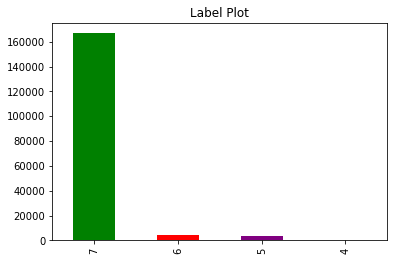

In [70]:
import matplotlib.pyplot as plt
counts = X_train['Number_of_Labels'].value_counts()
print(counts)
counts.plot(kind = 'bar',color = ["green","red", "purple", "yellow"])
plt.title('Label Plot')
plt.show()


This is understandable because most DNS attacks are encrypted, and longer DNS queries are indicative of data being exfiltrated

In [ ]:
X_train['Count_of_UpperCase'].nunique()

73

In [ ]:
X_train['Average_length_of_Labels'].describe()

count    175000.000000
mean         70.601474
std           8.795603
min           8.600000
25%          67.000000
50%          72.875000
75%          75.875000
max          87.875000
Name: Average_length_of_Labels, dtype: float64

From this, we can see that the dns queries have similar label length as the std is low.

In [ ]:
null_data = X_train[X_train.isnull().any(axis=1)]

In [ ]:
null_data

,Encoded_data,Length_of_Subdomain,Number_of_Labels,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Entrophy


In [27]:
X_train.isnull().sum().sum()

0

**Feature Enginieering done**

Let us obtain oly the features of our dataset to buil a ML model

In [28]:
train_data = X_train[['FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars',
       'Entrophy']]
train_data

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy
0,611,600,7,151,75.500,78,54,354,118,4.389699
1,539,528,7,150,66.500,72,40,326,94,4.530118
2,498,487,7,144,61.375,82,38,279,92,4.469136
3,590,579,7,150,72.875,75,49,348,111,4.481219
4,626,615,7,162,77.375,96,41,359,123,4.311626
...,...,...,...,...,...,...,...,...,...,...
174995,605,594,7,150,74.750,89,49,344,116,4.426524
174996,504,493,7,142,62.125,74,38,291,94,4.493035
174997,629,618,7,163,77.750,105,41,352,124,4.335566
174998,546,535,7,153,67.375,69,36,326,108,4.230303


**Preprocessing the test data**

In [29]:
# temp table
columns = ['Encoded_data', 'FQDN_count', 'Length_of_Subdomain',  'Number_of_Labels',  'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Entrophy' ]
tempFeatures2 = pd.DataFrame(columns=columns)
tempFeatures2

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy


In [31]:
for index, row in X_test.iterrows():
    tempFeatures2 = tempFeatures2.append({"Encoded_data": row[0],
                                      "FQDN_count": FQDN_count(row[0]),
                                      "Length_of_Subdomain": countOfCharsinSubdomain(row[0]),
                                      "Number_of_Labels": numOfLables(row[0]),
                                      "Maximun_label_length": maxLabelLength(row[0]), 
                                      "Average_length_of_Labels": AvgLengthOfLabels(row[0]), 
                                      "Count_of_Numbers": numOfDigits(row[0]) ,
                                      "Count_of_UpperCase": countUppercase(row[0]),
                                      "Count_of_LowerCase": countLowerCase(row[0]),
                                      "Count_of_SpecialChars": countSpecialChars(row[0]),           
                                      "Entrophy": find_entropy(row[0])}, ignore_index=True)
 

In [32]:
tempFeatures2

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy
0,b'0qoacY2\xeeAH\xd4m\xd0\xd7\xf6\xdb\xf0\xbd\x...,620,609,7,153,76.625,91,45,356,121,4.356736
1,b'0yqa8\xcf\xc9\xd3JiG\xbe\xee\xf8uV\xe9\xc8\x...,641,630,7,155,79.250,95,47,364,128,4.268468
2,b'0vjbdv\xd2b\xc738\xe2L\xe3B\xc1\xebL\xee\xbf...,504,493,7,157,62.125,78,35,290,94,4.393889
3,b'0ucat82\xbew\xeesJ\xf9aabacuqe1DxKabag\xca\x...,527,516,7,147,65.000,59,55,316,90,4.627084
4,b'0ula5Zo\xd8\xfdfg\xf5\xf8\xea\xe4W\xcci\xd0\...,566,555,7,154,69.875,73,53,330,103,4.527153
...,...,...,...,...,...,...,...,...,...,...,...
74995,b'0bjbst\xe048\xd9\xc6\xd8K\xf8\xd3\xd2I\xc8YJ...,489,478,7,145,60.250,83,42,268,89,4.533155
74996,b'0eeah82\xbew\xeesJ\xf9aabacuqe1m\xc1Kabag\xe...,527,516,7,132,65.000,85,48,297,90,4.656191
74997,b'0bcal\xed5k\xcd0M\xdb\xf6X\xde\xc1U\xe1ZG\xe...,611,600,7,160,75.500,100,49,337,118,4.393216
74998,b'0i2a7d\xe8r\xd6\xe4\xc4\xbc4S\xe9\xe6\xdf\xc...,626,615,7,159,77.375,96,35,365,123,4.299324


In [33]:
X_test =  tempFeatures2.copy()

In [34]:
X_test

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy
0,b'0qoacY2\xeeAH\xd4m\xd0\xd7\xf6\xdb\xf0\xbd\x...,620,609,7,153,76.625,91,45,356,121,4.356736
1,b'0yqa8\xcf\xc9\xd3JiG\xbe\xee\xf8uV\xe9\xc8\x...,641,630,7,155,79.250,95,47,364,128,4.268468
2,b'0vjbdv\xd2b\xc738\xe2L\xe3B\xc1\xebL\xee\xbf...,504,493,7,157,62.125,78,35,290,94,4.393889
3,b'0ucat82\xbew\xeesJ\xf9aabacuqe1DxKabag\xca\x...,527,516,7,147,65.000,59,55,316,90,4.627084
4,b'0ula5Zo\xd8\xfdfg\xf5\xf8\xea\xe4W\xcci\xd0\...,566,555,7,154,69.875,73,53,330,103,4.527153
...,...,...,...,...,...,...,...,...,...,...,...
74995,b'0bjbst\xe048\xd9\xc6\xd8K\xf8\xd3\xd2I\xc8YJ...,489,478,7,145,60.250,83,42,268,89,4.533155
74996,b'0eeah82\xbew\xeesJ\xf9aabacuqe1m\xc1Kabag\xe...,527,516,7,132,65.000,85,48,297,90,4.656191
74997,b'0bcal\xed5k\xcd0M\xdb\xf6X\xde\xc1U\xe1ZG\xe...,611,600,7,160,75.500,100,49,337,118,4.393216
74998,b'0i2a7d\xe8r\xd6\xe4\xc4\xbc4S\xe9\xe6\xdf\xc...,626,615,7,159,77.375,96,35,365,123,4.299324


In [35]:
X_test.to_csv("Test2_Data.csv", index=False)

In [36]:
X_test = pd.read_csv("Test2_Data.csv")
X_test

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy
0,b'0qoacY2\xeeAH\xd4m\xd0\xd7\xf6\xdb\xf0\xbd\x...,620,609,7,153,76.625,91,45,356,121,4.356736
1,b'0yqa8\xcf\xc9\xd3JiG\xbe\xee\xf8uV\xe9\xc8\x...,641,630,7,155,79.250,95,47,364,128,4.268468
2,b'0vjbdv\xd2b\xc738\xe2L\xe3B\xc1\xebL\xee\xbf...,504,493,7,157,62.125,78,35,290,94,4.393889
3,b'0ucat82\xbew\xeesJ\xf9aabacuqe1DxKabag\xca\x...,527,516,7,147,65.000,59,55,316,90,4.627084
4,b'0ula5Zo\xd8\xfdfg\xf5\xf8\xea\xe4W\xcci\xd0\...,566,555,7,154,69.875,73,53,330,103,4.527153
...,...,...,...,...,...,...,...,...,...,...,...
74995,b'0bjbst\xe048\xd9\xc6\xd8K\xf8\xd3\xd2I\xc8YJ...,489,478,7,145,60.250,83,42,268,89,4.533155
74996,b'0eeah82\xbew\xeesJ\xf9aabacuqe1m\xc1Kabag\xe...,527,516,7,132,65.000,85,48,297,90,4.656191
74997,b'0bcal\xed5k\xcd0M\xdb\xf6X\xde\xc1U\xe1ZG\xe...,611,600,7,160,75.500,100,49,337,118,4.393216
74998,b'0i2a7d\xe8r\xd6\xe4\xc4\xbc4S\xe9\xe6\xdf\xc...,626,615,7,159,77.375,96,35,365,123,4.299324


In [37]:
X_test.isnull().sum().sum()

0

In [38]:
test_data = X_test[['FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars',
       'Entrophy']]
test_data

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy
0,620,609,7,153,76.625,91,45,356,121,4.356736
1,641,630,7,155,79.250,95,47,364,128,4.268468
2,504,493,7,157,62.125,78,35,290,94,4.393889
3,527,516,7,147,65.000,59,55,316,90,4.627084
4,566,555,7,154,69.875,73,53,330,103,4.527153
...,...,...,...,...,...,...,...,...,...,...
74995,489,478,7,145,60.250,83,42,268,89,4.533155
74996,527,516,7,132,65.000,85,48,297,90,4.656191
74997,611,600,7,160,75.500,100,49,337,118,4.393216
74998,626,615,7,159,77.375,96,35,365,123,4.299324


**Since our dataset contains data for only one class. We shall use the one-class SVM**

In [39]:
from sklearn.svm import OneClassSVM

In [40]:
x = train_data.values

In [41]:
len(x)

175000

In [42]:
clf = OneClassSVM(kernel='rbf', gamma=0.003, nu=0.003)
#clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.003)

In [43]:
# since it is a one class svm, we will use recall as our evaluation measure
clf.fit(train_data)
pred = clf.predict(train_data)

In [44]:
# extract the negative outputs as the outliers
from numpy import  where
outlier_index = where(pred==-1)
outliers = x[outlier_index]

In [45]:
len(outliers)

608

There were 608 misclassifed records

We will only be able to find the recall (TP/(TP+FN)), since we only have positive documents that can be classified as true positives (TP, i.e., OCSVM got it right) or false negatives (FN, i.ie, the OCSVM was wrong).

In [46]:

print("Recall for the training data is: " +  str((len(x) -len(outliers))/len(x)))

Recall for the training data is: 0.9965257142857142


In [47]:
y =test_data.values

In [48]:
test_pred = clf.predict(test_data)

In [49]:
outlier_index = where(test_pred==-1)
outliers = y[outlier_index]

In [50]:
len(outliers)

443

In [51]:
print("Recall for the test data is: " +  str((len(y) -len(outliers))/len(y)))

Recall for the test data is: 0.9940933333333334


Now, let us try predicting the values for benign dns queries

In [52]:
benign_df = pd.read_csv("Benign_domains.csv")
benign_df

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy
0,rinnai.us,9,0,2,6,4.000000,0,0,8,0,2.725481
1,crowdfunder.com,15,0,2,11,7.000000,0,0,14,0,3.373557
2,mynews3.tv,10,0,2,7,4.500000,1,0,8,0,3.321928
3,thriftymamafurniture.com,24,0,2,20,11.500000,0,0,23,0,3.657268
4,terragotech.com,15,0,2,11,7.000000,0,0,14,0,3.240224
...,...,...,...,...,...,...,...,...,...,...,...
99995,bendigobank.com.au,18,11,3,11,5.333333,0,0,16,0,3.614369
99996,long-horn-steak-house.biz,25,0,2,21,12.000000,0,0,21,3,3.943465
99997,snaponsmile.com,15,0,2,11,7.000000,0,0,14,0,3.373557
99998,jamstockex.com,14,0,2,10,6.500000,0,0,13,0,3.378783


In [53]:
benign_data = benign_df[['FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars',
       'Entrophy']]
benign_data

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy
0,9,0,2,6,4.000000,0,0,8,0,2.725481
1,15,0,2,11,7.000000,0,0,14,0,3.373557
2,10,0,2,7,4.500000,1,0,8,0,3.321928
3,24,0,2,20,11.500000,0,0,23,0,3.657268
4,15,0,2,11,7.000000,0,0,14,0,3.240224
...,...,...,...,...,...,...,...,...,...,...
99995,18,11,3,11,5.333333,0,0,16,0,3.614369
99996,25,0,2,21,12.000000,0,0,21,3,3.943465
99997,15,0,2,11,7.000000,0,0,14,0,3.373557
99998,14,0,2,10,6.500000,0,0,13,0,3.378783


In [58]:
vals =benign_data.values

In [59]:
test_pred = clf.predict(vals)

In [60]:
outlier_index = where(test_pred==1)
outliers = vals[outlier_index]

In [61]:
len(outliers)

0

In [62]:
print("Recall for the benign  data is: " +  str((len(vals) -len(outliers))/len(vals)))

Recall for the benign  data is: 1.0


**Due to some features being significantly larger than others, let us try normalizing the features**

In [24]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
# fit scaler on training data
norm = MinMaxScaler().fit(train_data)
# transform training data
X_train_norm = norm.transform(train_data)

In [25]:
X_train_norm

array([[0.85067873, 0.85067873, 1.        , ..., 0.73611111, 0.8251928 ,
        0.42834596],
       [0.74208145, 0.74208145, 1.        , ..., 0.54166667, 0.75321337,
        0.57258565],
       [0.68024133, 0.68024133, 1.        , ..., 0.51388889, 0.63239075,
        0.50994446],
       ...,
       [0.87782805, 0.87782805, 1.        , ..., 0.55555556, 0.82005141,
        0.37274   ],
       [0.75263952, 0.75263952, 1.        , ..., 0.48611111, 0.75321337,
        0.26461273],
       [0.92307692, 0.92307692, 1.        , ..., 0.56944444, 0.90488432,
        0.25302407]])

In [26]:
clf = OneClassSVM(kernel='rbf', gamma=0.003, nu=0.003)

In [27]:
clf.fit(X_train_norm)
pred = clf.predict(X_train_norm)

In [29]:
# extract the negative outputs as the outliers
from numpy import  where
outlier_index = where(pred==-1)
outliers = X_train_norm[outlier_index]

In [30]:
len(outliers)

526

In [31]:
print("Recall for the normalized training data is: " +  str((len(X_train_norm) -len(outliers))/len(X_train_norm)))

Recall for the normalized training data is: 0.9969942857142857


In [32]:
X_test_norm = norm.transform(test_data)

In [33]:
pred = clf.predict(X_test_norm)

In [34]:
# extract the negative outputs as the outliers
from numpy import  where
outlier_index = where(pred==-1)
outliers = X_test_norm[outlier_index]

In [35]:
len(outliers)

188

In [36]:
print("Recall for the normalized test data is: " +  str((len(X_test_norm) -len(outliers))/len(X_test_norm)))

Recall for the normalized test data is: 0.9974933333333333


From this we can see that the normalized dataset perfromed slightly better than the unnormalized dataset.
We obtain a recall of 0.99 for the one-class SVM.

##**iForest**

In [64]:
 from sklearn.ensemble import IsolationForest

Let us start with small values of our hyperparamenters.
We have n-estimators set to 2, and we test for 1-20 for height of trees. 

In [65]:
# This function trains and tests given datasets and returns a list of recall scores
def train_and_evaluate(train, test):
    train_scores = []
    test_scores = []
    for i in range (1, 20):
        print("Start training")
        print("iForest with " + str(i) + " trees")
        clf = IsolationForest(n_estimators=2, max_samples=i, contamination=float(0.1), random_state=0)
        x=train.values
        clf.fit(x)
        pred= clf.predict(x)
        from numpy import  where
        outlier_index = where(pred==-1)
        outliers = x[outlier_index]
        score = (len(train) -len(outliers))/len(train)
        train_scores.append(score)
        y = test.values
        y_pred = clf.predict(y)
        outlier_index = where(y_pred==-1)
        outliers = y[outlier_index]
        score_test = (len(test) -len(outliers))/len(test)
        test_scores.append(score_test)
        print("Done training")
    return train_scores, test_scores


In [66]:
# Plots the train and the test scores
def plotScores(scores_train, scores_test):
    # Plot the points
    plt.figure(figsize=(10, 6))
    plt.plot([i+1 for i in range(len(scores_train))], scores_train)
    plt.plot([i+1 for i in range(len(scores_test))], scores_test)
    # Setup the legend
    plt.legend(["Train scores", "Test Scores"])
    # Labels for the x and y axis
    plt.ylabel("Recall")
    plt.xlabel("Iteration")
    plt.show()

In [67]:
train_scores, test_scores = train_and_evaluate(train_data,test_data)

Start training
iForest with 1 trees
Done training
Start training
iForest with 2 trees


C:\Users\Owner\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:451: RuntimeWarning: invalid value encountered in true_divide
  -depths


Done training
Start training
iForest with 3 trees
Done training
Start training
iForest with 4 trees
Done training
Start training
iForest with 5 trees
Done training
Start training
iForest with 6 trees
Done training
Start training
iForest with 7 trees
Done training
Start training
iForest with 8 trees
Done training
Start training
iForest with 9 trees
Done training
Start training
iForest with 10 trees
Done training
Start training
iForest with 11 trees
Done training
Start training
iForest with 12 trees
Done training
Start training
iForest with 13 trees
Done training
Start training
iForest with 14 trees
Done training
Start training
iForest with 15 trees
Done training
Start training
iForest with 16 trees
Done training
Start training
iForest with 17 trees
Done training
Start training
iForest with 18 trees
Done training
Start training
iForest with 19 trees
Done training


In [68]:
print(len(train_scores))

19


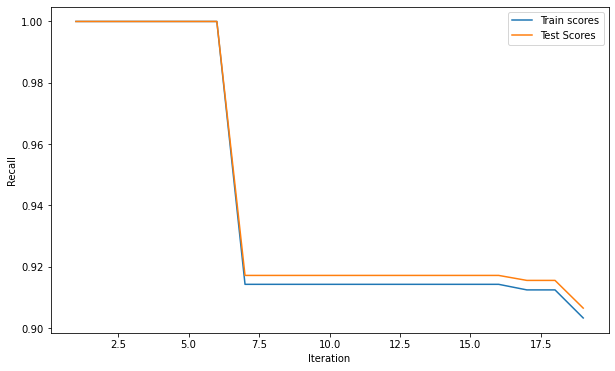

In [71]:
plotScores(train_scores, test_scores)

**As we can see from the graph above recall scores for the test and train data peak at the fifth iteration , i.e where max_samples=6. Therefore our algorithm would have n_estimators=2, max_samples=6, contamination=float(0.1)**

**The iForest algorithm perfoms better with a recall of 100% compared to a recall of 99% for the one-class SVM**

## using Iforest for benign dns queries

In [73]:
# we have selected an iForest with n_estimators=2, max_samples=6, contamination=float(0.1)
clf = IsolationForest(n_estimators=2, max_samples=6, contamination=float(0.1), random_state=0)
x=benign_data.values
clf.fit(x)
pred= clf.predict(x)
from numpy import  where
outlier_index = where(pred==11)
outliers = x[outlier_index]
score = (len(x) -len(outliers))/len(x)
print("Recall for the normalized training data is: " +  str(score))

Recall for the normalized training data is: 1.0


For the benign DNS queries we have a recall of 100%